Here, you develop the exact spatial derivative operator and its unit test.

In [1]:
import os.path
from scipy import *
import numpy as np
from numpy import *
from numpy import linalg as LA
from scipy import linalg as LA2
import sympy as sympy
import sys as sys
import time
import matplotlib.pyplot as plt
import itertools as it
from IPython.core.display import HTML


sys.path.append('/Users/sashacurcic/SashasDirectory/ANAG/FV_MG/')
from Modules import BasicTools as BT
from Modules import WaveTools as WT
from Modules import PlotTools as PT
from Modules import FFTTools as FFTT
from Modules import OperatorTools as OT
from Modules import GridTransferTools as GTT
from Modules import TestTools as TT
from Modules import SolverTools as ST
from Modules import WaveformTools as WFT

display(HTML("<style>pre { white-space: pre !important; }</style>"))
np.set_printoptions( linewidth = 10000, threshold = 100000)

In [2]:
# Grid parameters.
nh_min = 64
refRatio = 2
cfInter = int(nh_min / refRatio)

# Time integration parameters.
CFL = np.sqrt(0.5)
nt = 100
deriv = 'CD'
RK = 4
order = 2

# Waveform parameters.
x_0 = 0.
x_1 = float(cfInter) / float(nh_min)

# Physical parameters.
L = 1e-3
locs = []#x_1]
epsilons_r = [1]#, 11.68]
mus_r = [1]#, 0.99837]

# Pseudo-FFT parameters.
Hans = False

Initialize `Grid` ($\Omega^{(AMR)}$) and `PhysProps` objects to a two-level half-refined grid in a uniform material.

In [3]:
omega = BT.Grid(nh_min)
finehalf = list(np.arange(cfInter))# + int(nh / refRatio))
omega.AddPatch(refRatio, finehalf)

physics = BT.PhysProps(omega, epsilons_r, mus_r, locs, L)

In [4]:
# ----------------------------------------------------------------------------------------------------------------
# Function: TestResults
# ----------------------------------------------------------------------------------------------------------------
# By: Sasha Curcic
#
# This function performs a test on the residuals of some waveform propagated through some medium
# ----------------------------------------------------------------------------------------------------------------
# Inputs:
#
# omega                   Grid                    Object containing all grid attributes
# t                       float                   Inert parameter included for flexibility of use
# u0                      array                   Initial waveform in space-space of length degFreed
# c                       float                   Constant value
# order                   float                   Inert parameter included for flexibility of use
# ----------------------------------------------------------------------------------------------------------------
# Outputs:
#
# u                       array                   Derivative of initial waveform in space-space of length degFreed
# ----------------------------------------------------------------------------------------------------------------

In [5]:
# [THIS FUNCTION IS NOT SET UP TO HANDLE ANYTHING BUT THE HANSLESS NULLSPACE SELECTION MATRIX!]

def TestResults(omegaAMR, physicsAMR, nt_max, CFL, normType, RK, diff, opType, order, waveFunc, *argsW):
    startTime =  time.time()
    
    # SEE ABOUT GETTING RID OF/ALTERING THIS!!!
    TimeIntFunc, DiffFunc = TT.SolverSwitch(deriv, RK)
    
    # Unpack attributes from omegaAMR.
    nh_min = omegaAMR.nh_min
    nh_max = omegaAMR.nh_max
    
    # Create grid objects for uniform coarse and fine grid.
    omegaC = BT.Grid(nh_min)
    omegaF = BT.Grid(nh_max)
    
    # Unpack attributes from physicsAMR.
    epsilons_r = physicsAMR.epsilons_r
    mus_r = physicsAMR.mus_r
    L = physicsAMR.L
    locs = physicsAMR.locs
    cVecAMR = physicsAMR.cVec
    cMatAMR = physicsAMR.cMat
    
    # Create physics objects for uniform coarse and fine grid.
    physicsC = BT.PhysProps(omegaC, epsilons_r, mus_r, locs, L)
    physicsF = BT.PhysProps(omegaF, epsilons_r, mus_r, locs, L)
    
    # Unpack necessary attributes from physicsC and physicsF.
    cVecC = physicsC.cVec
    cMatC = physicsC.cMat
    cVecF = physicsF.cVec
    cMatF = physicsF.cMat
    
    # Find Fourier matrices for coarse, fine, and AMR grid.
    wavesAMR = WT.MakeWaves(omegaAMR)
    wavesC = WT.MakeWaves(omegaC)
    wavesF = WT.MakeWaves(omegaF)
    
    # Find nullspace and restriction operators for given AMR grid.
    nullspace = OT.FindNullspace(omegaAMR, wavesAMR)
    restrictOp = GTT.CoarsenOp(omegaAMR)
    
    # WRITE SOME SHIT FOR OPTYPE ARGUMENT!!!
    opC = -cMatC @ OT.SpaceDeriv(omegaC, order, diff)
    opF = -cMatF @ OT.SpaceDeriv(omegaF, order, diff)
    opAMR = -cMatAMR @ OT.SpaceDeriv(omega, order, diff)
    
    # Create exact Fourier derivative operators for coarse, fine, and AMR grid.
    derivMatC = OT.ExactSpatDerivOp(omegaC)
    derivMat = OT.ExactSpatDerivOp(omegaAMR) # Works on fine grid to produce results on AMR grid!
    
    # Create exact spatial operators for coarse, fine, and AMR grid.
    spatOpC = -cMatC @ derivMatC
    spatOp = -cMatF @ derivMat # Works on fine grid to produce results on AMR grid!
    
    # Find initial waveform on coarse, fine, and AMR grid.
    waveInitC = waveFunc(omegaC, *argsW)
    waveInitF = waveFunc(omegaF, *argsW)
    waveInitAMR = restrictOp @ waveInitF
    
    # Find Fourier coefficients for initial condition on coarse, fine, and AMR grid.
    FCoefsC = FFTT.FourierCoefs(wavesC, waveInitC)
    FCoefsF = FFTT.FourierCoefs(wavesF, waveInitF)
    FCoefsAMR = FFTT.FourierCoefs(wavesAMR @ nullspace, waveInitAMR)
    
    # Create arrays for storing error at each timestep.
    errorC = np.zeros(nt_max, float)
    errorF = np.zeros(nt_max, float)
    errorAMR = np.zeros(nt_max, float)
    timesteps = np.arange(nt_max) + 1
    
    # Iterate through timesteps to find error.
    for s in range(nt_max):
        
        print('iteration:', s)
        
        # Find time elapsed and timesteps by which to propagate solution.
        t, nt = ST.CalcTime(omegaAMR, CFL, cMatAMR, nt = s + 1)
        ntC = int((s + 1) / 2)

        # Create matrix exponential time integration operator for coarse, fine, and AMR grid.
        timePropOpC = LA2.expm(t * spatOpC)
        timePropOp = LA2.expm(t * spatOp) # Works on fine grid to produce results on AMR grid!

        # Find exact propagated coeficients on coarse and fine grid using exact Fourier derivative matrix exponential.
        # THESE OUTPUTS ARE NEEDED FOR PLOTTING INITIAL COURSE AND FINE WAVEFORM! (EXACT VALUES)
        FCoefsPropC = timePropOpC @ FCoefsC
        FCoefsPropF = timePropOp @ FCoefsF
        
        # Find exact propagated waveform on coarse and fine grid using exact Fourier derivative matrix exponential.
        # THESE OUTPUTS ARE NEEDED FOR FINDING COARSE ARE FINE ERROR IN WAVEFORM! (EXACT VALUES)
        wavePropC = wavesC @ FCoefsPropC
        wavePropF = wavesF @ FCoefsPropF

        # Find propagated waveform on AMR grid by restricting fine waveform.
        # THIS OUTPUT IS NEEDED FOR FINDING AMR ERROR IN WAVEFORM! (EXACT VALUES)
        wavePropAMR = restrictOp @ wavePropF

        # Find exact propagated coefficients on AMR grid.
        # THIS OUTPUT IS NEEDED FOR PLOTTING PROPAGATED AMR WAVEFORM! (EXACT VALUES)
        FCoefsPropAMR = FFTT.FourierCoefs(wavesAMR @ nullspace, wavePropAMR)

        # Find propagated coeficients on coarse, fine, and AMR grid using RK solver.
        # THIS OUTPUT IS NEEDED FOR PLOTTING 
        solverCoefsC = ST.RungeKutta(omegaC, physicsC, wavesC, waveInitC, ntC, CFL, RK, opC) # TimeIntFunc(omegaC, physicsC, wavesC, waveInitC, ntC, CFL, opC) # (omegaC, wavesC, waveInitC, ntC, cMatC, CFL, DiffFunc)
        solverCoefsF = ST.RungeKutta(omegaF, physicsF, wavesF, waveInitF, nt, CFL, RK, opF) # TimeIntFunc(omegaF, physicsF, wavesF, waveInitF, nt, CFL, opF) # (omegaF, wavesF, waveInitF, nt, cMatF, CFL, DiffFunc)
        solverCoefsAMR = ST.RungeKutta(omegaAMR, physicsAMR, wavesAMR @ nullspace, waveInitAMR, nt, CFL, RK, opAMR) # TimeIntFunc(omegaAMR, physicsAMR, wavesAMR @ nullspace, waveInitAMR, nt, CFL, opAMR) # (omega, wavesAMR @ nullspace, waveInitAMR, nt, cMat, CFL, DiffFunc, order = order)
        
        # Find propagated waveform on coarse, fine, and AMR grid from RK solver.
        solverWaveC = wavesC @ solverCoefsC
        solverWaveF = wavesF @ solverCoefsF
        solverWaveAMR = wavesAMR @ nullspace @ solverCoefsAMR

        # Find absolute difference between solver waveform and exact waveform on coarse, fine, and AMR grid.
        errorsC = abs(wavePropC - solverWaveC)
        errorsF = abs(wavePropF - solverWaveF)
        errorsAMR = abs(wavePropAMR - solverWaveAMR)
        
        # Find error norm between solver waveform results and exact waveform results on coarse, fine, and AMR grid.
        errorC[s] = TT.VectorNorm(errorsC, normType)
        errorF[s] = TT.VectorNorm(errorsF, normType)
        errorAMR[s] = TT.VectorNorm(errorsAMR, normType)
    
    # Load initial and propagated coeficients for coarse, fine, and AMR grid into condensed arrays for plotting final propagation.
    allCoefsC = PT.Load(FCoefsC, FCoefsPropC, solverCoefsC)
    allCoefsF = PT.Load(FCoefsF, FCoefsPropF, solverCoefsF)
    allCoefsAMR = PT.Load(FCoefsAMR, FCoefsPropAMR, solverCoefsAMR)

    # Create labels for plots.
    labels = ['Initial Wave', 'Exact Derivative Propagated Wave', 'RK Propagated Wave']

    PT.PlotMixedWave(omegaC, waves = wavesC, FCoefs = allCoefsC, rescale = 5, yGrid = True, labels = labels, title = 'Coarse-Grid Mode Propagation')
    PT.PlotMixedWave(omegaF, waves = wavesF, FCoefs = allCoefsF, rescale = 5, yGrid = True, labels = labels, title = 'Fine-Grid Mode Propagation')
    PT.PlotMixedWave(omega, waves = wavesAMR, FCoefs = nullspace @ allCoefsAMR, rescale = 5, yGrid = True, labels = labels, title = 'AMR-Grid Mode Propagation')

    
    # INCLUDE IF STATEMENTS WHICH WOULD ADDITIONALLY CAUSE TESTRESULTS() TO COMPUTE ROTATION MATRIX AND DIRECT
    # PROPAGATED WAVEFORM CALCULATION IF C IS UNIFORM!
    endTime = time.time()
    totTime = endTime - startTime
    print('total time:', totTime)
    return timesteps, errorC, errorF, errorAMR

You are using ExactSpatDerivOp in OperatorTools module (which I believe is what you want)!
[[  0.  -0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.  -1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   1.   0.  -0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  

iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40
iteration: 41
iteration: 42
iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47
iteration: 48
iteration: 49
iteration: 50
iteration: 51
iteration: 52
iteration: 53
iteration: 54
iteration: 55
iteration: 56
iteration: 57
iteration: 58
iteration: 59
iteration: 60
iteration: 61
iteration: 62
iteration: 63
iteration: 64
iteration: 65
iteration: 66
iteration: 67
iteration: 68
iteration: 69
iteration: 70
iteration: 71
iteration: 72
iteration: 73
iteration: 74
iteration: 75
iteration: 76
iteration: 77
iteration: 78
iteration: 79
iteration: 80
iteration: 81
iteration: 82
iteration: 83
iterat

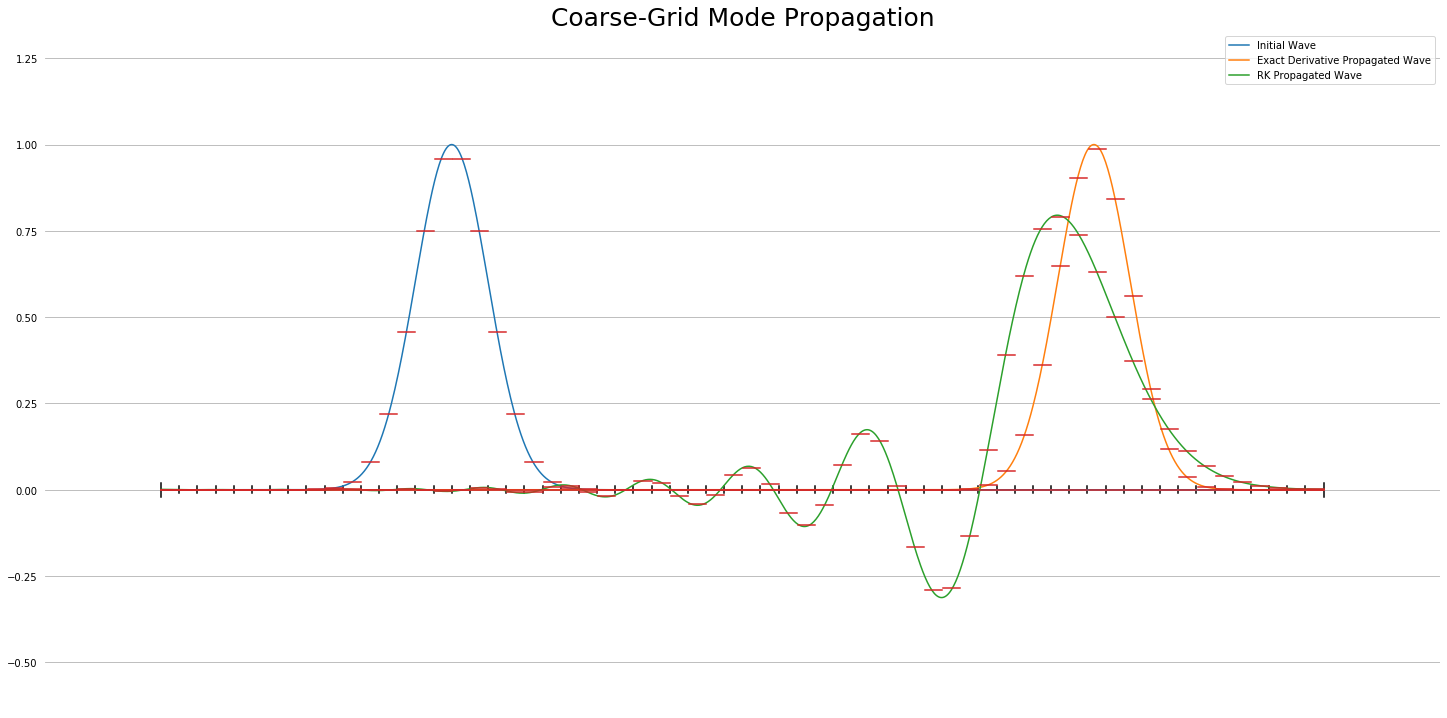

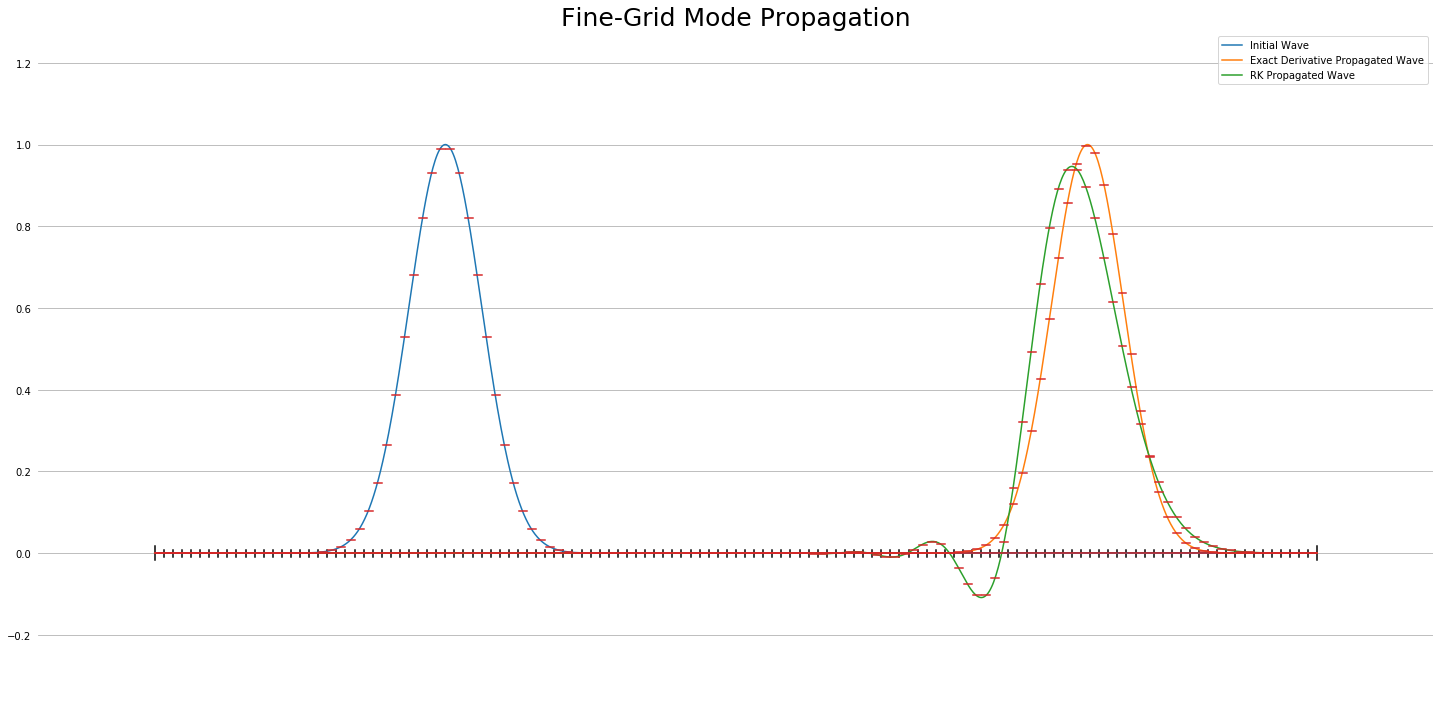

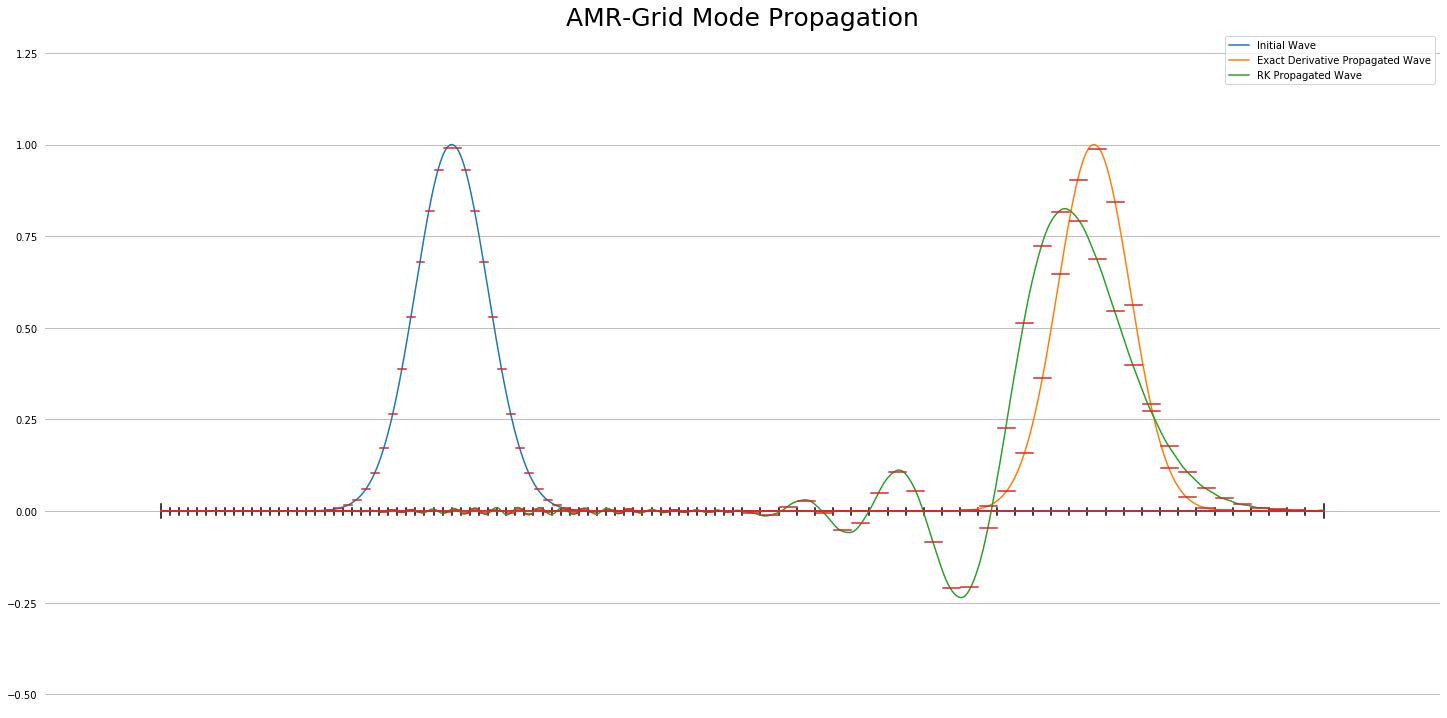

In [6]:
args = WFT.GaussParams(x_0, x_1) # sigma, mu
# print(type(args))
opType = 'grad'
timesteps, errorC, errorF, errorAMR = TestResults(omega, physics, nt, CFL, 'L2', RK, deriv, opType, order, WFT.Gauss, *args)
# print(blah)
# print(waveInitC)

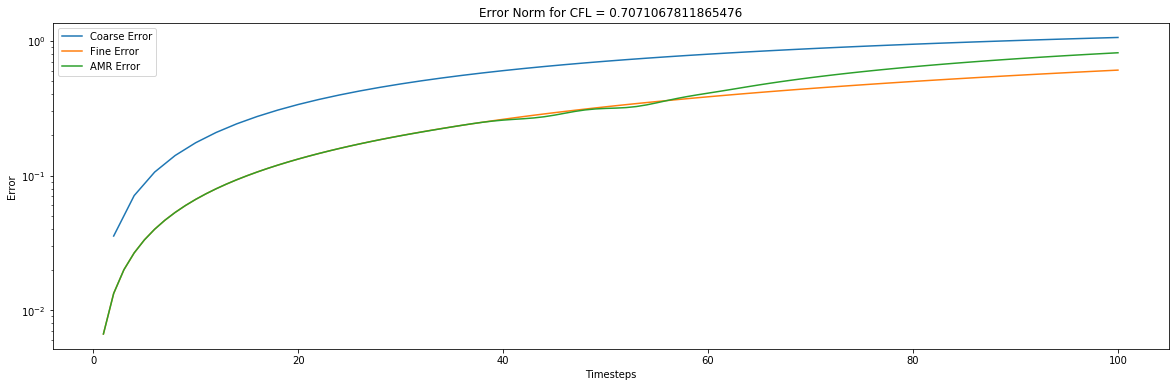

In [7]:
numPoints, font, X, savePath = PT.UsefulPlotVals()
saveName = savePath + 'DirectError.png'
title = 'Error Norm for CFL = ' + str(CFL)
fig, ax = plt.subplots(figsize = [20, 6])
plt.plot(timesteps[1::2], errorC[1::2], label = 'Coarse Error', color = PT.ColorDefault(0))
plt.plot(timesteps, errorF, label = 'Fine Error', color = PT.ColorDefault(1))
plt.plot(timesteps, errorAMR, label = 'AMR Error', color = PT.ColorDefault(2))
if (nt < 100):
    plt.scatter(timesteps[1::2], errorC[1::2], color = PT.ColorDefault(0))
    plt.scatter(timesteps, errorF, color = PT.ColorDefault(1))
    plt.scatter(timesteps, errorAMR, color = PT.ColorDefault(2))
plt.title(title)
plt.xlabel('Timesteps')
plt.ylabel('Error')
plt.legend()
# plt.ylim(-1, 1.1)
plt.yscale('log')
fig.savefig(saveName, bbox_inches = 'tight', dpi = 300)#, transparent = True)
plt.show()

In [8]:
# Notes for Hans:
#
# If the resolution is too low, there isn't sufficient high-frequency content to represent the gaussian.
# Sparse function needs to be developed for upwind and center-diffference of arbitrary-order polynomial interpolation.
# I see that I can't use the rotation matrix to propagate the matrices. I'm pretty sure that my Fourier-propagated logic is wrong, though.
# 2nd-order polynomial interp is working BETTER THAN 3rd-order for RK4 center diff.


In [9]:
# Notes for Sasha:
#
# Make residuals test of Gaussian (first unpropagated, then propagated) to assess its validity.



# Unpropagated:
# You already thoroughly tested Fourier Transform in ResidualsUnitTest.

# Propagated:
# You tested rotation matrix in ResidualsUnitTest.